# Demonstration of detection using scarlet primatives

This notebook is designed to serve an example as to how to use scarlet primatives to perform detection on a coadded image, as opposed to using single frame measurement task in the science pipelines.

It also includes an example of using wavelets for detection, which I contend will detect more real peaks with fewer spurrious detections in a crowded field than using the PSF convolved image.

# Imports

In [1]:
# Import Packages and setup
import os
import pickle
from functools import partial

import numpy as np
from astropy.io import fits

import scarlet
from scarlet import display
from scarlet import detect_pybind11 as detect

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a good colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='Greys_r', interpolation='none', origin='lower')

# Load data

Replace this cell to run on a different dataset. Requires both the multiband PSF and multiband image

In [2]:
# Import the cutouts that Michael selected for analysis
data_path = "/Users/fred3m/data/scarlet_resources"
file_name = "NGC_6569_cutout_{}.fits"
# Do not load iz, since the PSF I was given for this dataset in those bands is terrible
filters = "ugr"
images = [fits.open(os.path.join(data_path, file_name.format(f)))[0].data for f in filters]
images = np.asarray(images)
# Download the psf images
psf_path = "/Users/fred3m/data/Michael"
psf_filename = "PSF_{}.fits"
_psfs = [fits.open(os.path.join(psf_path, psf_filename.format(f)))[0].data for f in filters]
_psfs = np.asarray(_psfs)

# Only use the central part of the PSF (the original is 101x101)
bands, height, width = _psfs.shape
cy = (height-1)//2
cx = (width-1)//2
_psfs = _psfs[:, cy-20:cy+20, cx-20:cx+20]

# Display the PSF and image

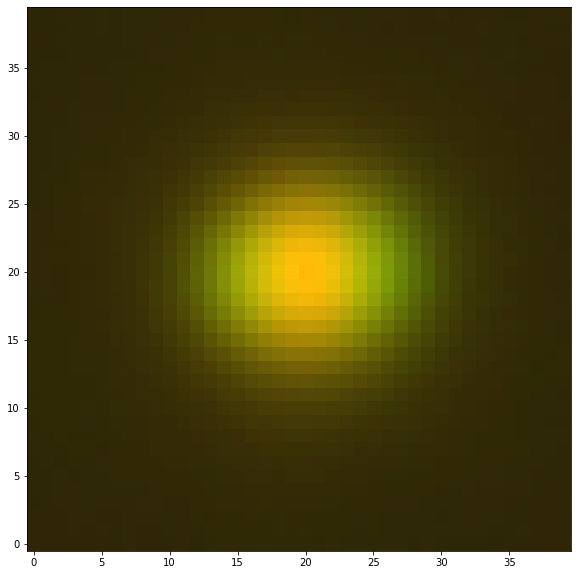

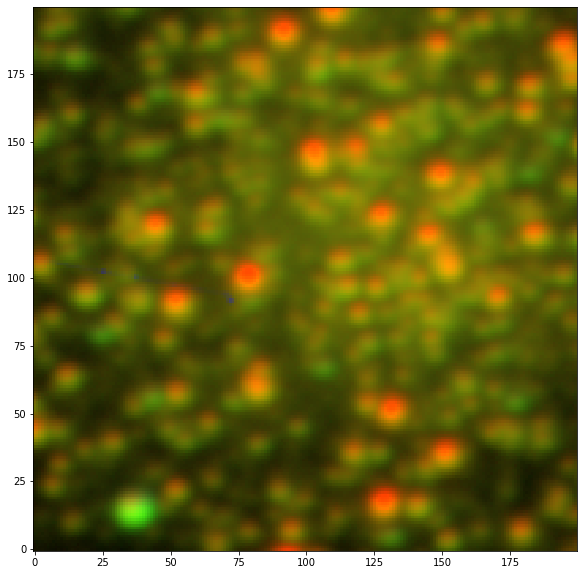

In [3]:
figsize=(10, 10)
norm = display.AsinhMapping(minimum=0, stretch=np.max(_psfs)*0.055, Q=10)
img_rgb = scarlet.display.img_to_rgb(_psfs, norm=norm)
plt.figure(figsize=figsize)
plt.imshow(img_rgb)
plt.show()

figsize = (10, 10)
norm = display.AsinhMapping(minimum=0, stretch=np.max(images)*0.055, Q=10)
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.figure(figsize=figsize)
plt.imshow(img_rgb)
plt.show()

# Detection on convolved images

We'll first do detection on the PSF convolved image, so we convovle the image in each band and detect n each band separately.

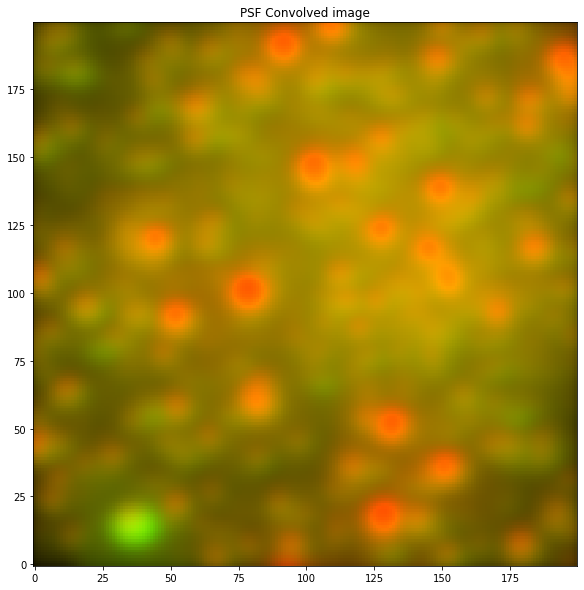

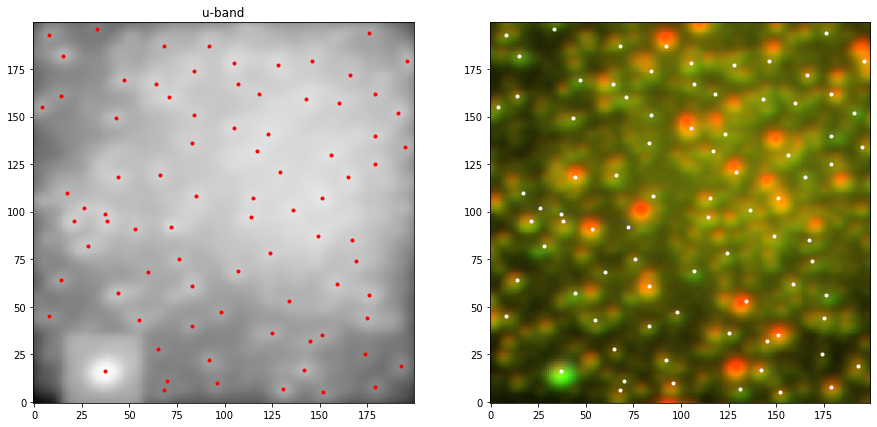

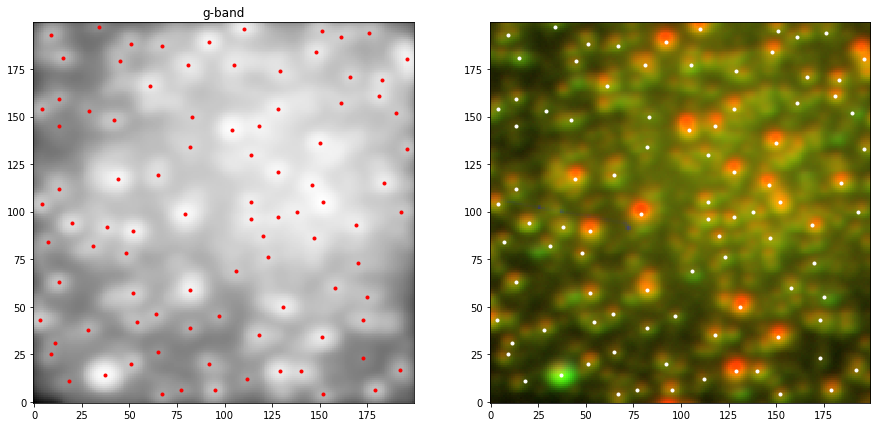

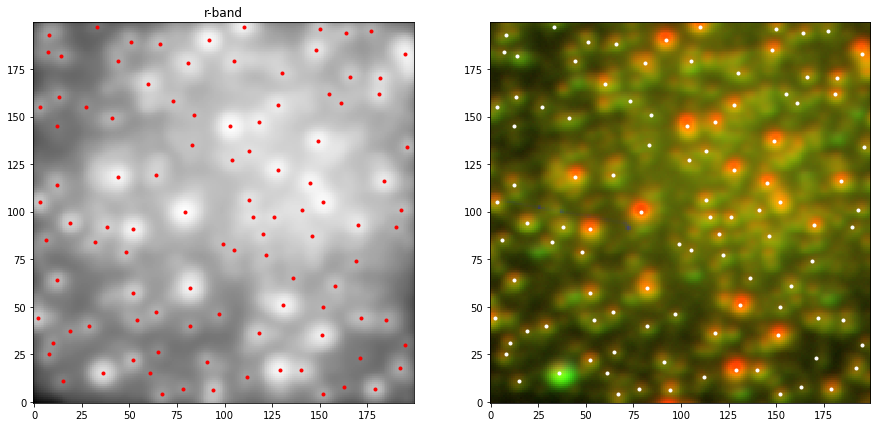

In [4]:
# Convovle with the PSF image in each band
convolved = scarlet.fft.convolve(images, _psfs, return_Fourier=False)

# Display the convolved image
norm = display.AsinhMapping(minimum=0, stretch=np.max(convolved)*0.055, Q=10)
img_rgb = scarlet.display.img_to_rgb(convolved, norm=norm)
plt.figure(figsize=figsize)
plt.imshow(img_rgb)
plt.title("PSF Convolved image")
plt.show()

norm = display.AsinhMapping(minimum=0, stretch=np.max(_psfs)*0.055, Q=10)
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)

# Detect and display each band
figsize=(15, 7)
for n, img in enumerate(convolved):
    # Detect peaks
    peaks = detect.get_peaks(img, 2.0, 0, 0)
    # Display the detection image with peaks marked
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    ax[0].imshow(np.arcsinh(10*img)/10)
    ax[0].set_title(f"{filters[n]}-band")
    x = [peak.x for peak in peaks]
    y = [peak.y for peak in peaks]
    ax[0].plot(x, y, "r.")
    # Display the full color image with peaks marked
    ax[1].imshow(img_rgb)
    ax[1].plot(x, y, "w.")
    plt.show()

# Detect on wavelet coefficients

Wavelets essentially distribute the flux for each source so that the bulk of the flux is moved to the center, with a negative ring around each source. The result is that it can be much better at detecting faint peaks in an image. 


Note: There are a lot of spurrious detections around the edge of the image. This is an artifact of the wavelet transform but is easily solved by increasing the size of the detection image removing edge detections.

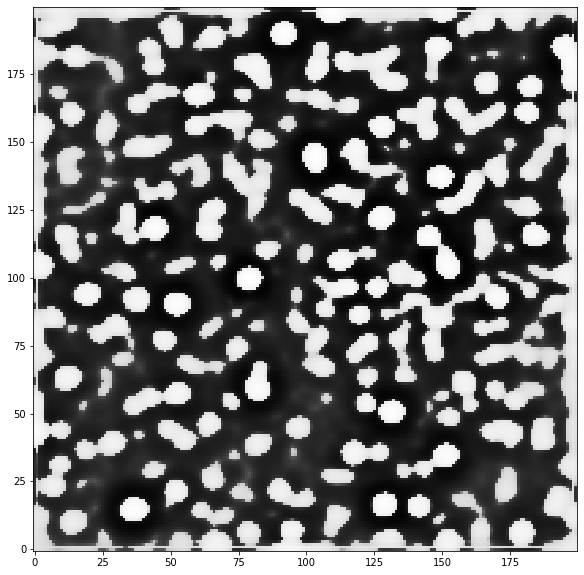

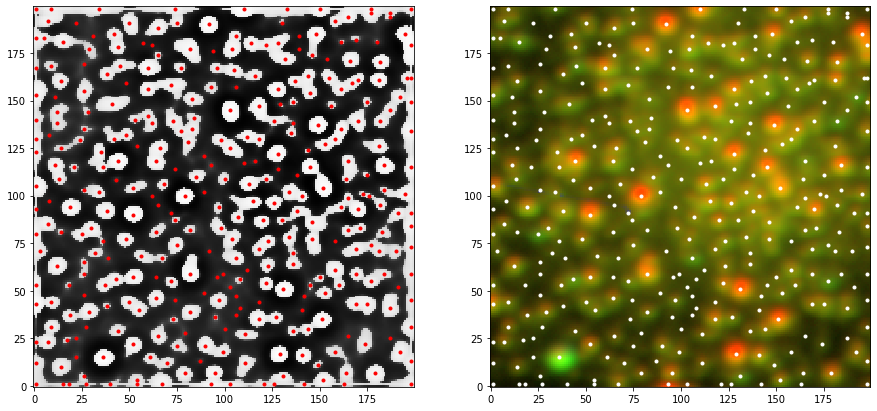

In [5]:
# Calculate the starlet coefficients for an image up to the 2nd wavelet scale
starlets = scarlet.wavelet.starlet_transform(np.sum(images, axis=0), scales=2)

# Display the 1st wavelet scale (the one used for detection)
plt.figure(figsize=(10, 10))
plt.imshow(np.arcsinh(10*starlets[1])/10)
plt.show()

# Get the peaks
peaks = detect.get_peaks(starlets[1], 2.0, 0, 0)
x = [peak.x for peak in peaks]
y = [peak.y for peak in peaks]

# Display the image and the peaks
fig, ax = plt.subplots(1, 2, figsize=figsize)
ax[0].imshow(np.arcsinh(10*starlets[1])/10)
ax[0].plot(x, y, "r.")
ax[1].imshow(img_rgb)
ax[1].plot(x, y, "w.")
plt.show()

# One last look at the full image

We mask the edge region and remove the edge sources to see the full catalog superimposed on the image.

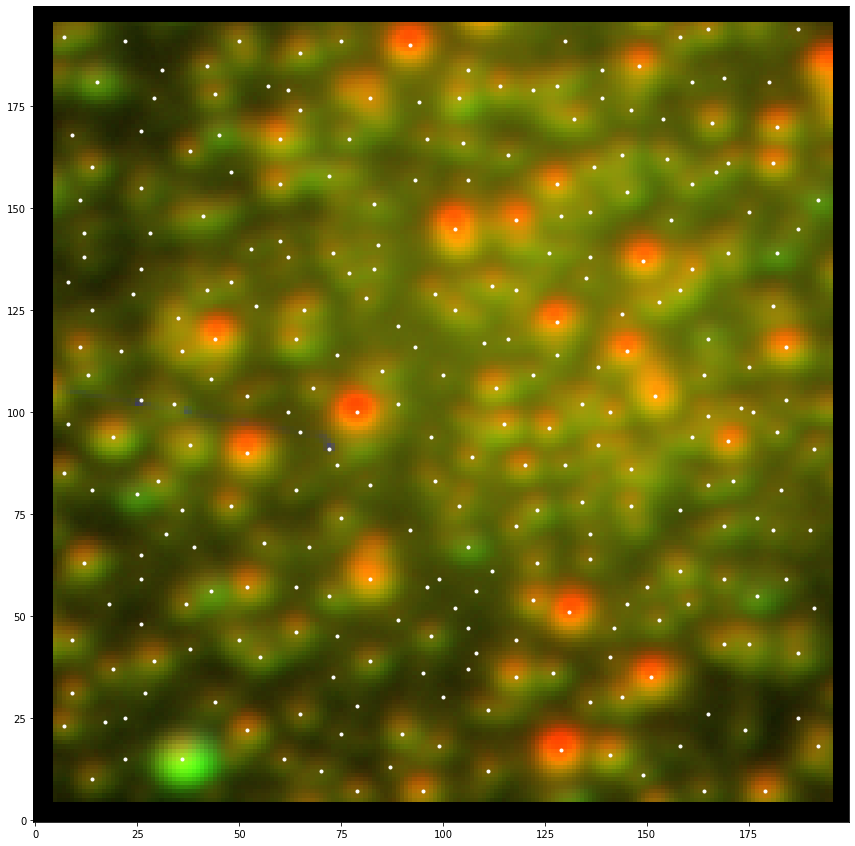

In [6]:
# Remove edge sources
edge = 5
bands, height, width = images.shape
x = np.array(x)
y = np.array(y)
cuts = (x>edge) & (x<width-edge) & (y>edge) & (y<height-edge)
x = x[cuts]
y = y[cuts]

# Mask out the edge region
mask = np.zeros(images[0].shape, dtype=bool)
X = np.arange(width)
Y = np.arange(height)
X,Y = np.meshgrid(X, Y)
mask[X<edge] = 1
mask[X>width-edge] = 1
mask[Y<edge] = 1
mask[Y>height-edge] = 1

# Display the image and the peaks
fig = plt.figure(figsize=(15, 15))
plt.imshow(img_rgb)
plt.imshow(np.ma.array(mask, mask=~mask))
plt.plot(x, y, "w.")
plt.show()